In [2]:
import subprocess
import os
from pathlib import Path
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import re
from gdxpds import to_dataframes
import numpy as np
import seaborn as sns

# Define paths
gams_model = "osemosys.gms"
results_folder = Path("Results")
results_folder.mkdir(exist_ok=True)

scenario = "parametrised_py"
data = "template"
storage = "yes"  # or "no"

*Remember to change the path to your own gams executable in the next codeblock (line 2), found by typing 'where gams' into a terminal*

In [3]:
#user-defined declarations
results_folder = "Results" #path to results folder
gams_exe ="/Library/Frameworks/GAMS.framework/Versions/49/Resources/gams" #path to GAMS executable
osemosys_exe = os.path.join(os.getcwd(),"osemosys.gms") #path to OSeMOSYS model

def extract_results(selected_files = None):
    """
    For each (scen, data, stor) in selected_files, load the corresponding file and return
    a list of OrderedDicts (from to_dataframes), in the same order as selected_files.
    """
    print("Loading results...")
    results = []
    results_dir = os.path.join(os.getcwd(), results_folder)
    pattern = re.compile(r"results_SCEN(?P<scen>\w+)_DATA(?P<data>\w+)_STOR(?P<stor>yes|no)\.gdx")

    file_lookup = {}
    for filename in os.listdir(results_dir):
        match = pattern.match(filename)
        if match:
            key = (match.group("scen"), match.group("data"), match.group("stor"))
            file_lookup[key] = os.path.join(results_dir, filename)
    
    if selected_files is not None:
        for triplet in selected_files:
            key = tuple(triplet)
            if key in file_lookup:
                filename = file_lookup[key]
                print(filename)
                results.append(to_dataframes(filename))
            else:
                print(f"{key} not found")
                results.append(None)

        return results
    else:
        for key, filename in file_lookup.items():
            print(filename)
            results.append(to_dataframes(filename))
        return results  

In [4]:
#Example
selected_files = [
    ["base", "template", "yes"],
    ["parametrised_py", "template", "yes"]
]

# a list of a dict of dataframes is returned from extract_results
# each list element corresponds to the contents of one gdx file
results = extract_results(selected_files=selected_files)
paramgdx = results[1]
display(paramgdx["CapitalInvestment"])
EMISSION = paramgdx["EMISSION"]["*"]

print("List of emission names, easily retrievable:\n",list(EMISSION))
#this is useful for plotting

# All the entries in the gdx file - sheets in the excel viewer
entries = set(paramgdx.keys())

#idea: analyse X across multiple dataframes e.g. [[AnnualEmission_CO2, TotalDiscountedCostByTechnology_IMPGAS, etc], YEAR] using more advanced techniques

Loading results...
/Users/hugosmart/Documents/Github/Hy-run/Results/results_SCENbase_DATAtemplate_STORyes.gdx
/Users/hugosmart/Documents/Github/Hy-run/Results/results_SCENparametrised_py_DATAtemplate_STORyes.gdx


,REGION,TECHNOLOGY,YEAR,Level,Marginal,Lower,Upper,Scale
0,GERMANY,IMPGAS,2024,0.0,0.0,0.0,inf,1.0
1,GERMANY,IMPGAS,2025,0.0,0.0,0.0,inf,1.0
2,GERMANY,IMPGAS,2026,0.0,0.0,0.0,inf,1.0
3,GERMANY,IMPGAS,2027,0.0,0.0,0.0,inf,1.0
4,GERMANY,IMPGAS,2028,0.0,0.0,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
670,GERMANY,IHC,2046,0.0,0.0,0.0,inf,1.0
671,GERMANY,IHC,2047,0.0,0.0,0.0,inf,1.0
672,GERMANY,IHC,2048,0.0,0.0,0.0,inf,1.0
673,GERMANY,IHC,2049,0.0,0.0,0.0,inf,1.0


List of emission names, easily retrievable:
 ['CO2', 'CO2_PP', 'CO2_TH']


In [ ]:
def plot_name(dictList, name, x_col, y_col, target, title=None, xlabel=None, ylabel=None):
    """
    Plot a dataframe with x and y columns.
    """
    dfList = []
    for i in range(0, len(dictList)):
        dfList.append(dictList[i][name])
    
    fig, axes = plt.subplots(nrows=len(dfList), ncols=1, figsize=(len(dfList)*5, 6))
    for i,df in enumerate(dfList):
        ax = axes[i]
        ax.plot(df['YEAR'], df['Level'], marker='o')
        ax.set_title(title if title else f"{y_col} vs {x_col}")
        ax.set_xlabel(xlabel if xlabel else x_col)
        ax.set_ylabel(ylabel if ylabel else y_col)
        ax.grid()
        #ax.legend([f"{df[target]}"])
        
    plt.show()

--- Job osemosys.gms Start 05/16/25 22:45:41 49.2.0 9b2b0844 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/GAMS.framework/Versions/49/Resources/gmsprmun.txt
--- GAMS Parameters defined
    Input /Users/hugosmart/Documents/Github/Hy-run/osemosys.gms
    ScrDir /Users/hugosmart/Documents/Github/Hy-run/225c/
    SysDir /Library/Frameworks/GAMS.framework/Versions/49/Resources/
    --scen parametrised_py
    --data template
    --stor yes
    --solvermode mip
Licensee: Massimo Tavoni                                 G250226+0003Ac-GEN
          Fondazione CMCC                                           DCE4109
          225c/gamslice.dat
          node:56901401 mem:8 cores:8 ipport:58946 v:2                     
          Course license for use within the course and related course work
          The expiration date of time-limited license is Sep 24, 2025
System information: 8 physical cores and 8 Gb memory detected
GAMS 49.2.0   Copyright (C) 1987-2025 GAMS Development. All ri

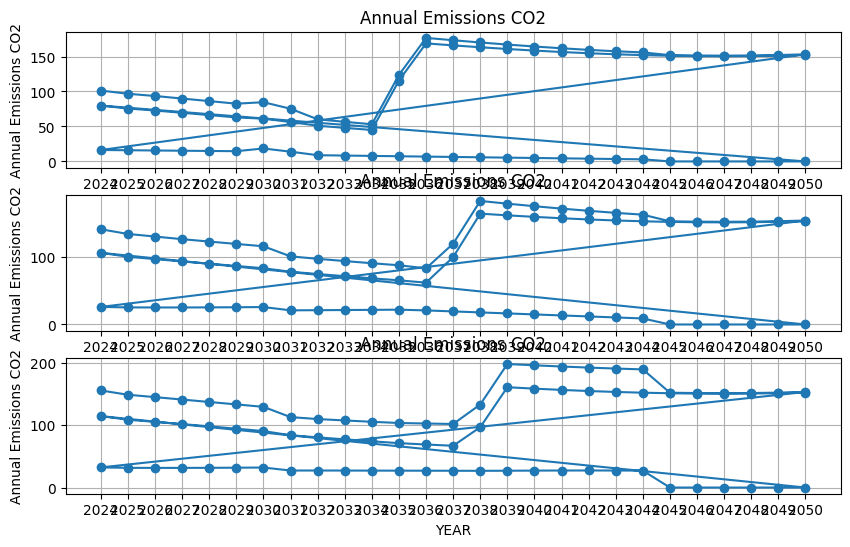

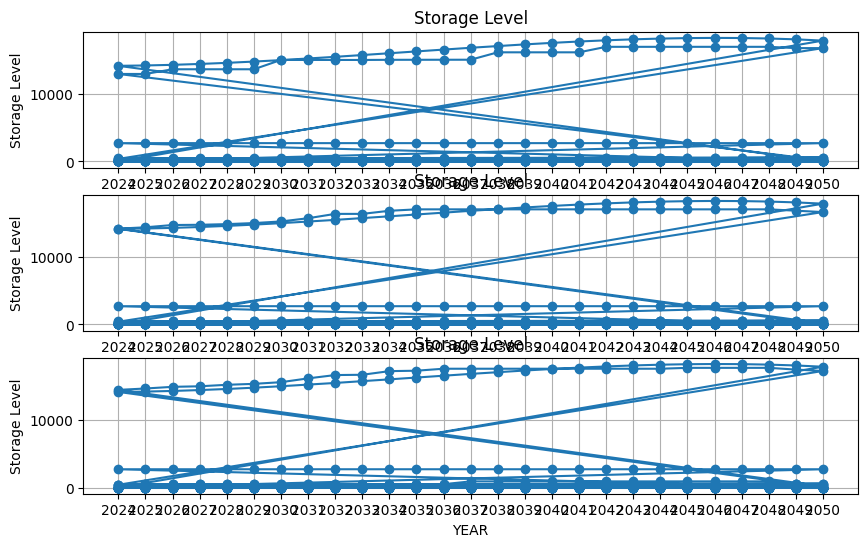

In [20]:
#parametrise and run:

# As example, we will choose to modify GEO CapitalCosts - normally is 4,200
parameterList = [200, 1000, 10000] 

selected_files = [
    ["parametrised_py", "template", "yes"]
]

dicts = {}
for i, p in enumerate(parameterList):
    with open("Input_template/parametrised_py.gms", "w") as f:
        f.write(f"CapitalCost('GERMANY','GEO',y) = {p};\n")
    
    subprocess.run([
        gams_exe, 
        osemosys_exe, 
        f"--scen=parametrised_py", 
        f"--data=template", 
        f"--stor=yes",
        "--solvermode=mip"
    ], check=True)

    results = extract_results(selected_files=selected_files)
    ourdict = results[0]
    print(ourdict.keys())
    dicts[i] = ourdict

dict = list(dicts.values())

plot_name(dicts, "AnnualEmissions", "YEAR", "Level", "EMISSION", title="Annual Emissions CO2", xlabel="YEAR", ylabel="Annual Emissions CO2")
plot_name(dicts, "AccumulatedNewCapacity", "YEAR", "Level", "TECHNOLOGY", title="Storage Level", xlabel="YEAR", ylabel="Storage Level")
#plotting in subplots for comparisons

In [ ]:
#ignore below

In [ ]:

#unique_techs = btot_cost_tech['TECHNOLOGY'].unique()


storage_techs = ['BEES', 'STOR_HYDRO']
techs_demand = ['FEU', 'IHE', 'IHG', 'IHC']
fossil_fuel_imports_techs = ['IMPGAS', 'GRIDGAS', 'IMPHCO1', 'IMPOIL1', 'IMPBIO1', 'VIR_SUN' 'VIR_WIN', 'VIR_GTH', 'VIR_HYD']
secondary_imports_techs = ['COAL', 'GFPP', 'ROR', 'OIL_GEN', 'BIO', 'GEO', 'SPV', 'WPP_ON', 'WPP_OFF', 'GRID_ELC']

,REGION,TECHNOLOGY,YEAR,Level,Marginal,Lower,Upper,Scale
0,GERMANY,IMPGAS,2024,199.196527,0.0,0.0,inf,1.0
1,GERMANY,IMPGAS,2025,153.223607,0.0,0.0,inf,1.0
2,GERMANY,IMPGAS,2026,145.927245,0.0,0.0,inf,1.0
3,GERMANY,IMPGAS,2027,138.978329,0.0,0.0,inf,1.0
4,GERMANY,IMPGAS,2028,129.490375,0.0,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
670,GERMANY,IHC,2046,648.475763,0.0,0.0,inf,1.0
671,GERMANY,IHC,2047,617.591777,0.0,0.0,inf,1.0
672,GERMANY,IHC,2048,588.179271,0.0,0.0,inf,1.0
673,GERMANY,IHC,2049,563.777021,0.0,0.0,inf,1.0


In [68]:
btot_cost_tech.columns

Index(['REGION', 'TECHNOLOGY', 'YEAR', 'Level', 'Marginal', 'Lower', 'Upper',
       'Scale'],
      dtype='object')

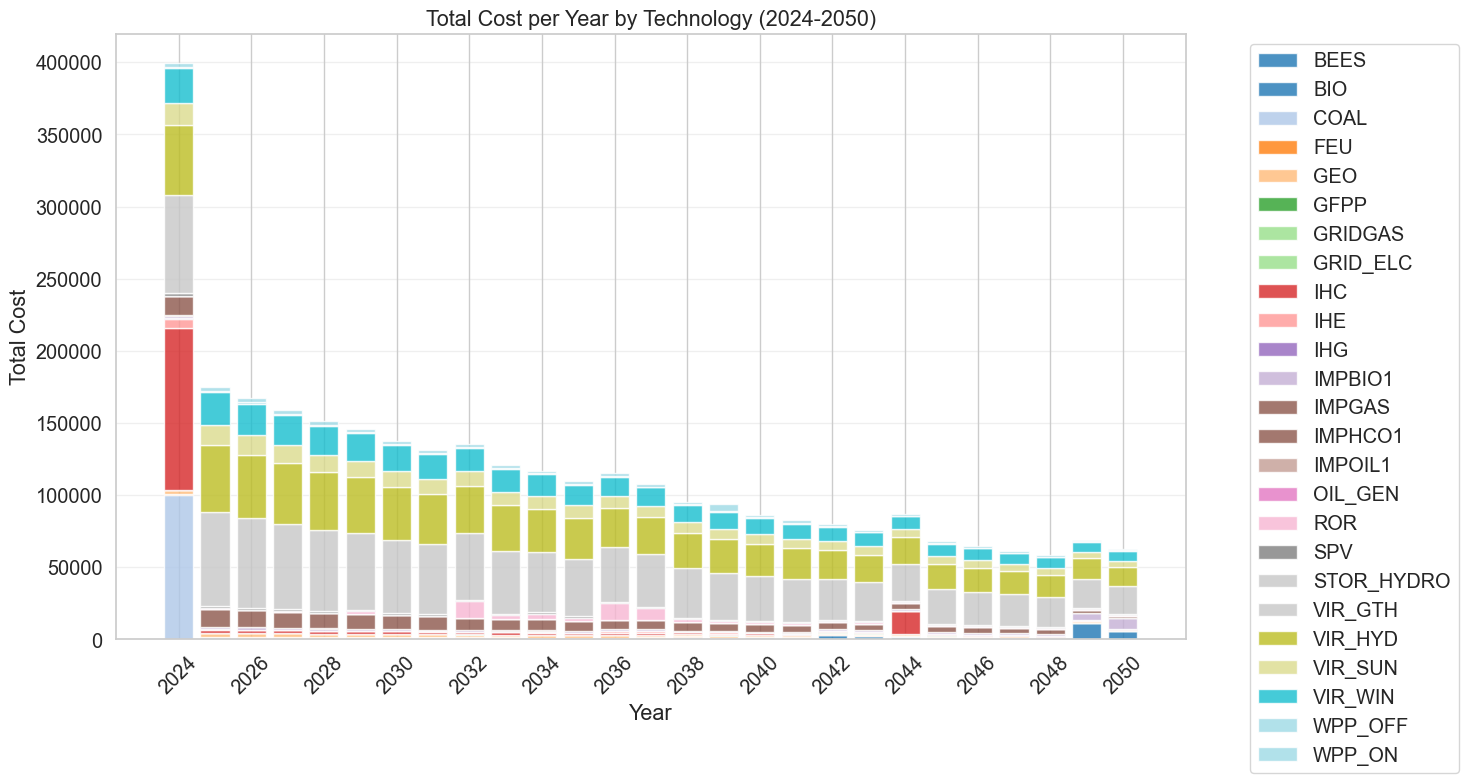

In [69]:
btot_cost_tech['YEAR'] = btot_cost_tech['YEAR'].astype(int)

filtered_data = btot_cost_tech[(btot_cost_tech['YEAR'] >= 2024) & (btot_cost_tech['YEAR'] <= 2050)]

pivot_data = filtered_data.pivot_table(index='YEAR', columns='TECHNOLOGY', values='Level', aggfunc='sum', fill_value=0)

plt.figure(figsize=(15, 8))
bottom = np.zeros(len(pivot_data))

technologies = pivot_data.columns
colors = plt.cm.tab20(np.linspace(0, 1, len(technologies)))

for i, tech in enumerate(technologies):
   plt.bar(pivot_data.index, pivot_data[tech], bottom=bottom, 
           label=tech, color=colors[i], alpha=0.8)
   bottom += pivot_data[tech]

plt.xlabel('Year')
plt.ylabel('Total Cost')
plt.title('Total Cost per Year by Technology (2024-2050)')
plt.xticks(range(2024, 2051, 2), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('total_cost_by_tech.png')

plt.show()

Fuel,ED,ELC1,ELC2,GAS,GAS2,GTH,HCO,HYD,IH,OIL,SUN,WBM,WIN
Year,,,,,,,,,,,,,
2024,252.6771,348.272018,323.892976,0.0,0.0,293.817146,613.880117,20.853722,562.31997,0.0,0.000000,0.000000e+00,33.601149
2025,253.6062,349.271050,324.822076,0.0,0.0,328.417327,602.972867,20.853722,553.59417,0.0,0.000000,0.000000e+00,0.000000
2026,255.2625,351.052018,326.478376,0.0,0.0,300.221069,591.779117,20.853722,544.63917,0.0,0.000000,0.000000e+00,29.977226
2027,257.5713,353.534598,328.787176,0.0,0.0,332.680876,580.370867,20.853722,535.51257,0.0,0.000000,0.000000e+00,0.000000
2028,260.4579,356.638469,331.673776,0.0,0.0,295.899936,568.820117,20.853722,526.27197,0.0,0.000000,0.000000e+00,39.884811
2029,263.8476,360.283308,335.063476,0.0,0.0,291.961187,557.198867,24.328762,516.97497,0.0,0.000000,3.410605e-13,43.993359
2030,267.6657,364.388792,338.881576,0.0,0.0,310.082803,545.579117,24.328762,507.67917,0.0,0.000000,0.000000e+00,29.977226
2031,271.8375,356.419779,331.470394,0.0,0.0,276.035642,548.511595,24.328762,498.44217,0.0,10.240974,0.000000e+00,45.814400
2032,276.2883,373.660405,347.504176,0.0,0.0,321.453971,522.632117,52.206434,489.32157,0.0,0.000000,0.000000e+00,0.000000


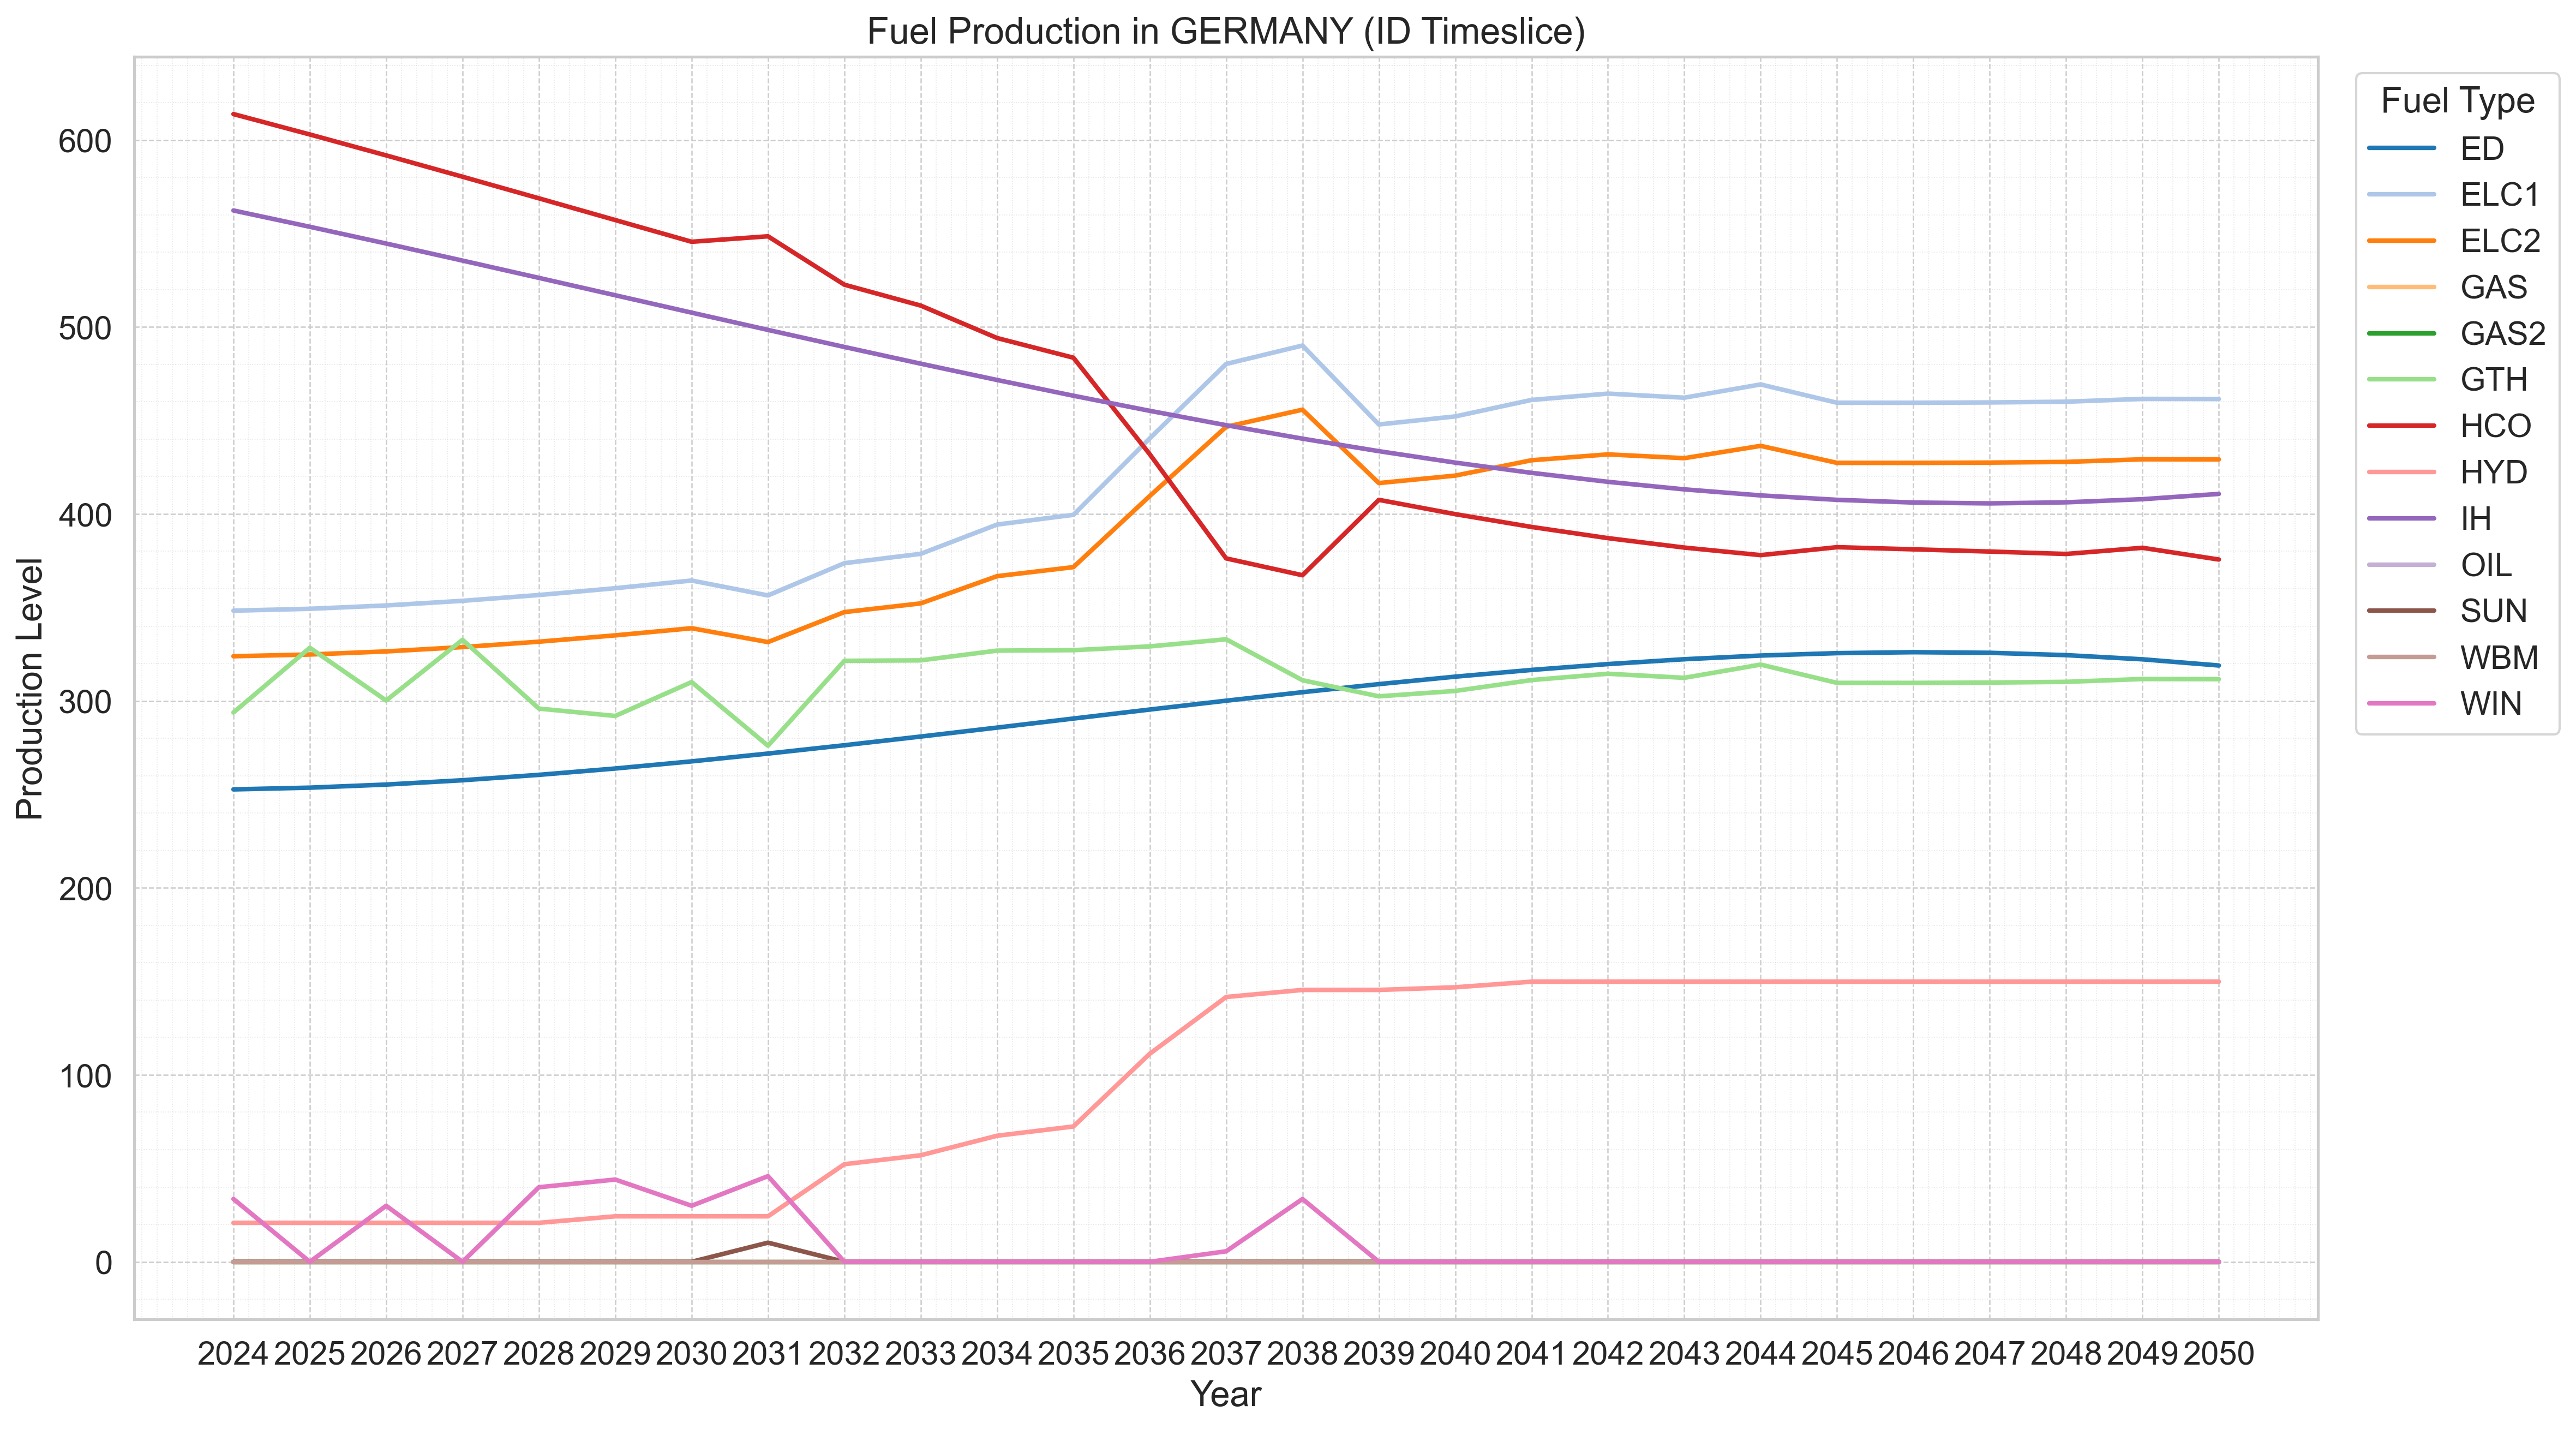

In [70]:
df1 = dfbase["Production"]
df1.columns = ['Region', 'Timeslice', 'Fuel', 'Year', 'Level', 'Marginal', 'Lower', 'Upper', 'Scale']

# Filter for a single region (Germany) and a chosen timeslice, e.g., 'ID'
region = 'GERMANY'
timeslice = 'ID'
df_filtered = df1[(df1['Region'] == region) & (df1['Timeslice'] == timeslice)]

# Pivot so fuels are columns
df_pivot = df_filtered.pivot(index='Year', columns='Fuel', values='Level')

display(df_pivot)

sns.set_theme(style="whitegrid", font_scale=1.3)


palette = sns.color_palette("tab20", n_colors=len(df_pivot.columns))
fuel_order = []

plt.figure(figsize=(16, 9), dpi=300)
for idx, fuel in enumerate(df_pivot.columns):
    fuel_order.append(fuel)
    sns.lineplot(x=df_pivot.index, y=df_pivot[fuel], label=fuel, color=palette[idx], linewidth=2)

plt.xlabel('Year')
plt.ylabel('Production Level')
plt.title(f'Fuel Production in {region} ({timeslice} Timeslice)', fontsize=16)

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.6)
plt.minorticks_on()
plt.grid(visible=True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.legend(title='Fuel Type', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)
plt.tight_layout()

plt.savefig('fuel_production_lineplot.png')

plt.show()

Index(['REGION', 'TECHNOLOGY', 'YEAR', 'Value'], dtype='object')


TECHNOLOGY,BIO,COAL,GEO,GFPP,GRIDGAS,GRID_ELC,IHC,IHE,IHG,IMPGAS,OIL_GEN,ROR,SPV,STOR_HYDRO,VIR_GTH,VIR_HYD,VIR_SUN,VIR_WIN,WPP_OFF,WPP_ON
YEAR,,,,,,,,,,,,,,,,,,,,
2024,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2025,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2026,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2027,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2028,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2029,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2030,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2031,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0
2032,4000.0,1200.0,4000.0,2000.0,0.7,1.5,1100.0,900.0,1015.0,882.0,2000.0,3000.0,900.0,400.0,3500.0,2500.0,883.0,1274.0,2550.0,1100.0


<Figure size 1600x900 with 0 Axes>

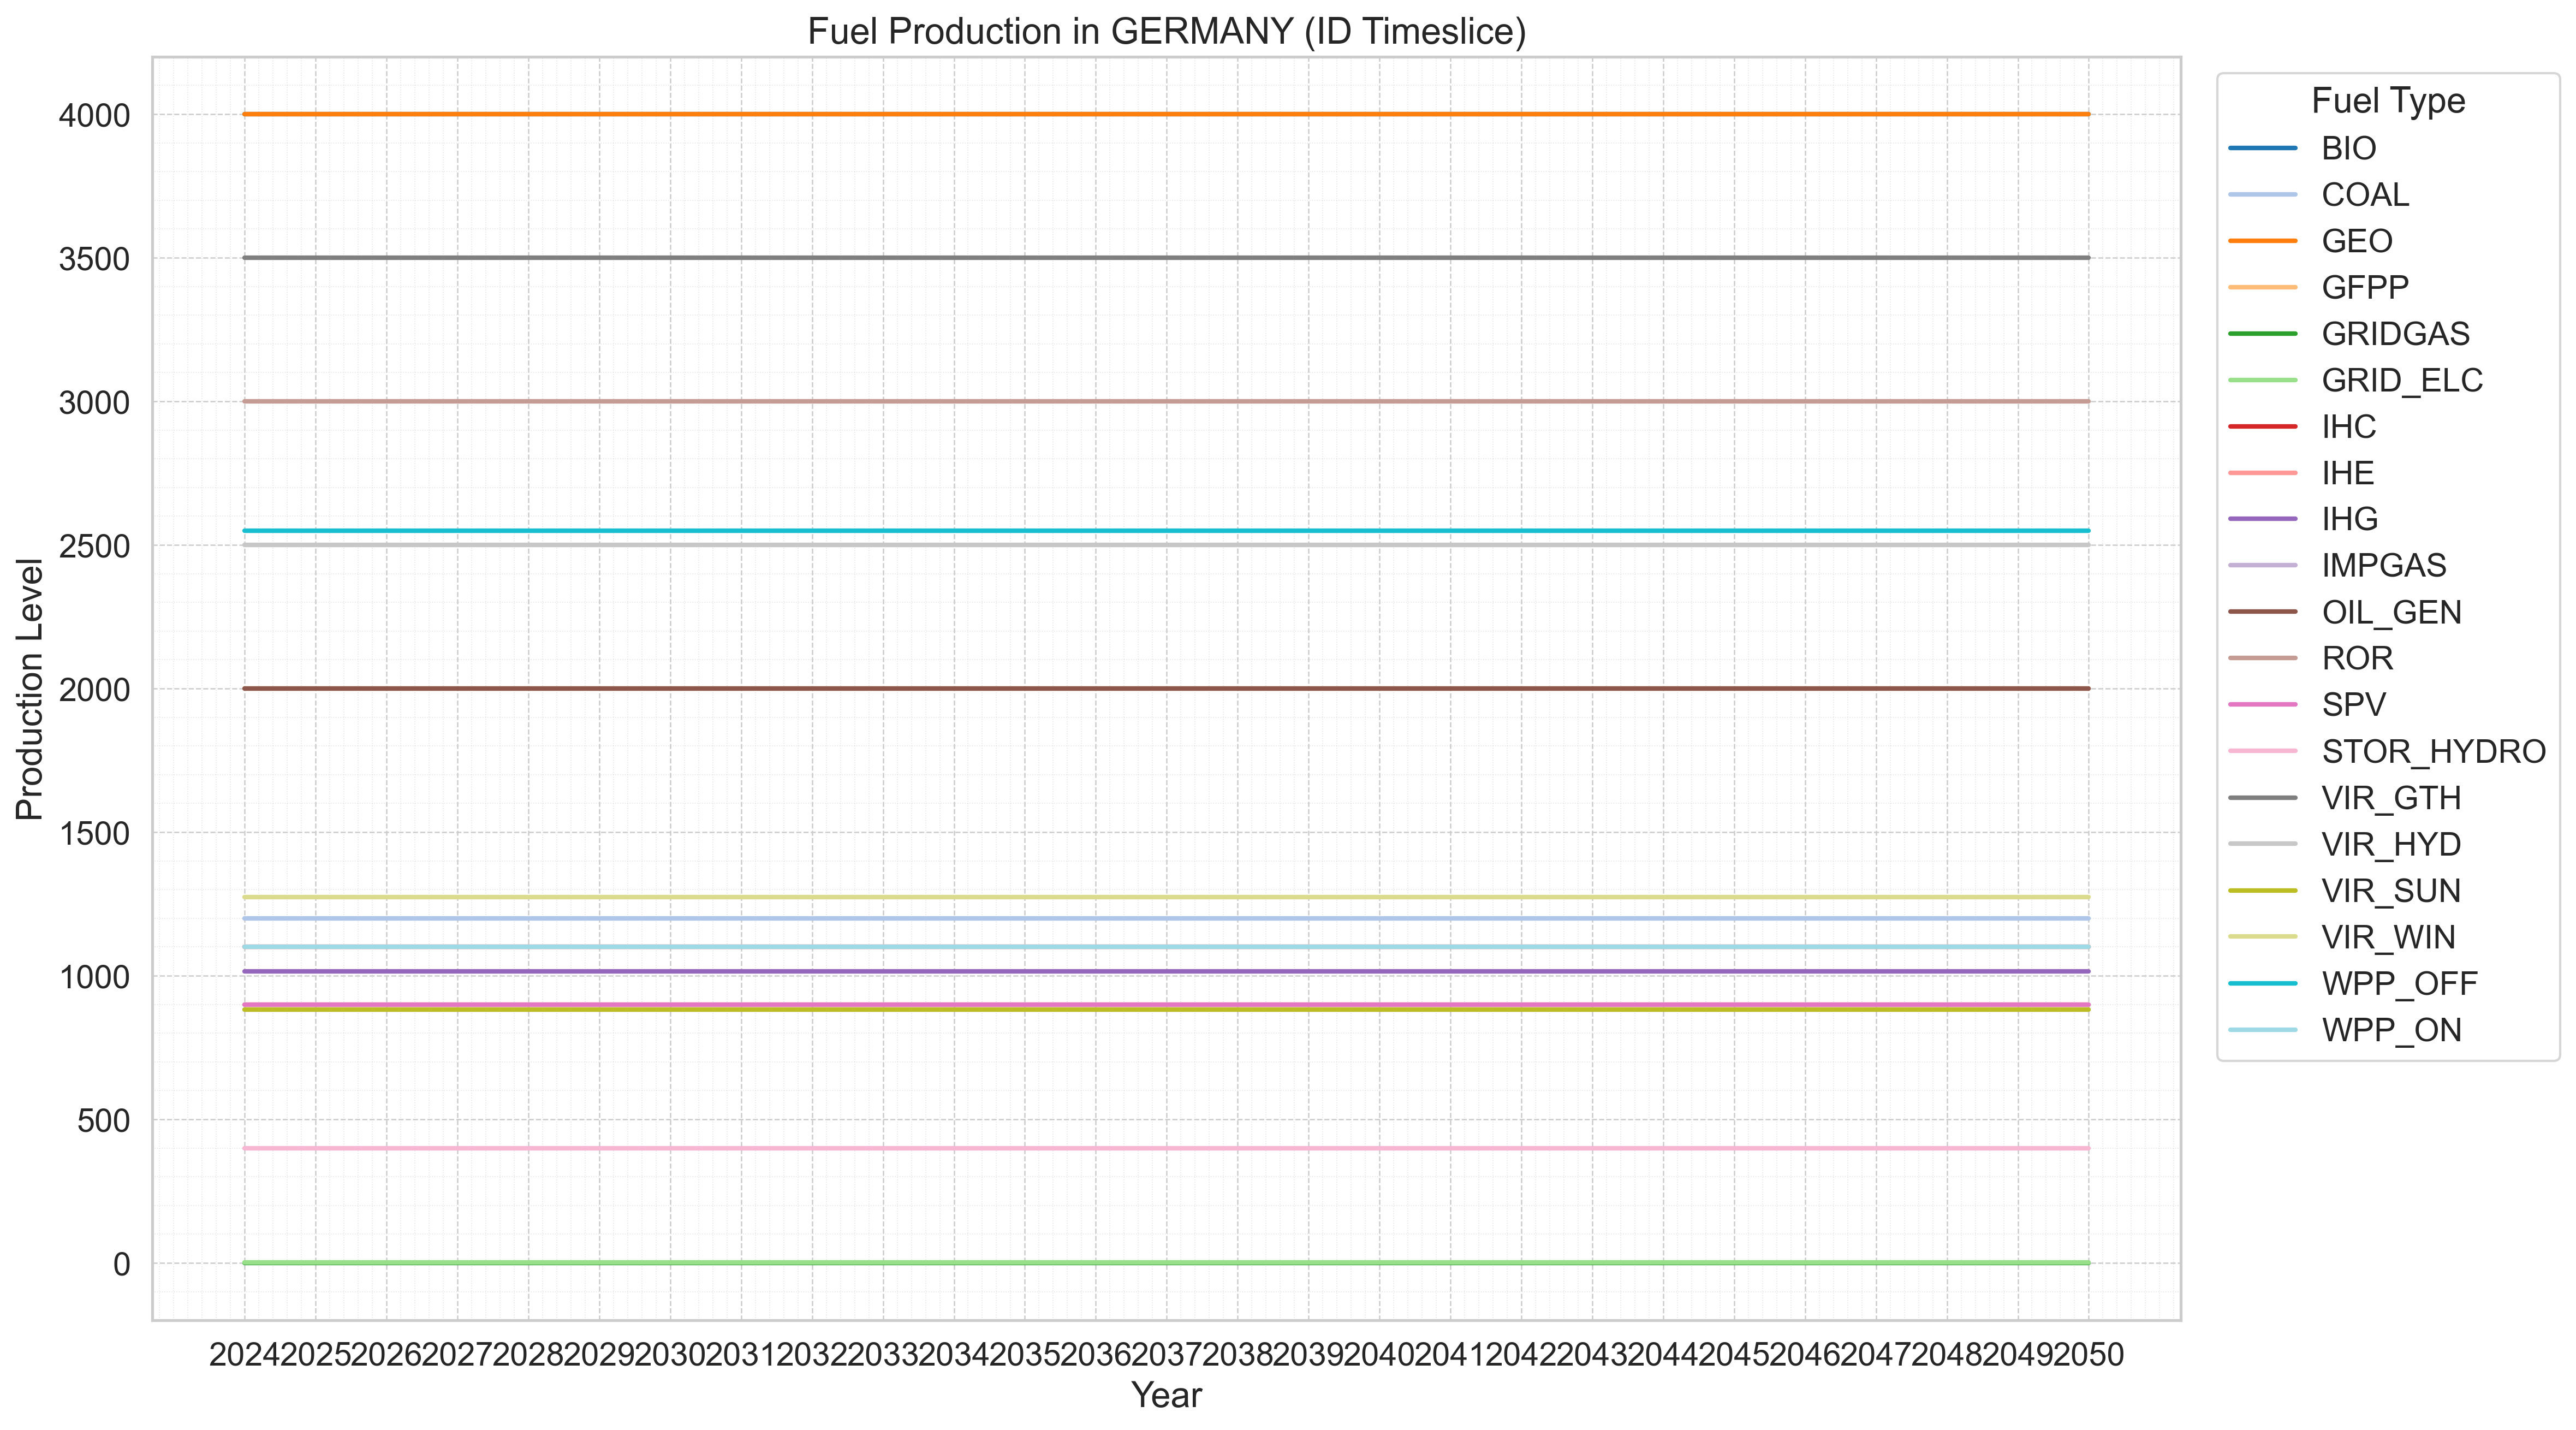

In [71]:
dfbase.keys()
print(dfbase["CapitalCost"].columns)

df_pivot = dfbase["CapitalCost"].pivot(index='YEAR', columns='TECHNOLOGY', values='Value')


display(df_pivot)
plt.figure(figsize=(16, 9))

sns.set_theme(style="whitegrid", font_scale=1.3)


palette = sns.color_palette("tab20", n_colors=len(df_pivot.columns))
tech_order = []

plt.figure(figsize=(16, 9), dpi=300)
for idx, tech in enumerate(df_pivot.columns):
    tech_order.append(tech)
    sns.lineplot(x=df_pivot.index, y=df_pivot[tech], label=tech, color=palette[idx], linewidth=2)

plt.xlabel('Year')
plt.ylabel('Production Level')
plt.title(f'Fuel Production in {region} ({timeslice} Timeslice)', fontsize=16)

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.6)
plt.minorticks_on()
plt.grid(visible=True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.legend(title='Fuel Type', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)
plt.tight_layout()

plt.savefig('fuel_production_lineplot.png')

plt.show()

# Parametrisation
So, we can pull gdx results directly to python! Can we write a gms file from python, solve the model, and then loop results directly into here?

In [ ]:
##sample parameters - N
N = 4

gamsparams = ["parametrised_py", "template", "yes"]

# Define the parameters to be varied
emissionC02min = 50
emissionC02max = 600  # Choose a range that makes sense for N
emissionC02step = (emissionC02max - emissionC02min) // (N - 1)
emissionC02 = np.arange(emissionC02min, emissionC02max + 1, emissionC02step)

dfs = {}

for i, e in enumerate(emissionC02):
    with open("Input_template/parametrised_py.gms", "w") as f:
        f.write(f"AnnualEmissionLimit('GERMANY',e,y) = {e};\n")
    
    subprocess.run([
        gams_exe, 
        osemosys_exe, 
        f"--scen=parametrised_py", 
        f"--data=template", 
        f"--stor=yes"
    ], check=True)

    df_results = extract_results(filter_list=[
        ("parametrised_py", "template", "yes") #only load parametrised_py results
    ])
    df = df_results["parametrised_py"]["template"]["yes"]
    print(df.keys())
    dfs[i] = df["AnnualEmissions"]



--- Job osemosys.gms Start 05/16/25 18:45:21 49.2.0 9b2b0844 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/GAMS.framework/Versions/49/Resources/gmsprmun.txt
--- GAMS Parameters defined
    Input /Users/hugosmart/Documents/Github/Hy-run/osemosys.gms
    ScrDir /Users/hugosmart/Documents/Github/Hy-run/225c/
    SysDir /Library/Frameworks/GAMS.framework/Versions/49/Resources/
    --scen parametrised_py
    --data template
    --stor yes
Licensee: Massimo Tavoni                                 G250226+0003Ac-GEN
          Fondazione CMCC                                           DCE4109
          225c/gamslice.dat
          node:56901401 mem:8 cores:8 ipport:49965 v:2                     
          Course license for use within the course and related course work
          The expiration date of time-limited license is Sep 24, 2025
System information: 8 physical cores and 8 Gb memory detected
GAMS 49.2.0   Copyright (C) 1987-2025 GAMS Development. All rights reserved
--- Sta

In [ ]:
print(dfs.items())
df = dfs[0]

dict_items([(0,      REGION EMISSION  YEAR       Level  Marginal  Lower  Upper  Scale
0   GERMANY      CO2  2024  261.859948       0.0    0.0    inf    1.0
1   GERMANY      CO2  2025  223.655613       0.0    0.0    inf    1.0
2   GERMANY      CO2  2026  199.375835       0.0    0.0    inf    1.0
3   GERMANY      CO2  2027  198.006634       0.0    0.0    inf    1.0
4   GERMANY      CO2  2028  195.665963       0.0    0.0    inf    1.0
..      ...      ...   ...         ...       ...    ...    ...    ...
76  GERMANY   CO2_TH  2046  150.599559       0.0    0.0    inf    1.0
77  GERMANY   CO2_TH  2047  150.428011       0.0    0.0    inf    1.0
78  GERMANY   CO2_TH  2048  150.641389       0.0    0.0    inf    1.0
79  GERMANY   CO2_TH  2049  151.261051       0.0    0.0    inf    1.0
80  GERMANY   CO2_TH  2050  152.308359       0.0    0.0    inf    1.0

[81 rows x 8 columns]), (1,      REGION EMISSION  YEAR       Level  Marginal  Lower  Upper  Scale
0   GERMANY      CO2  2024  261.859948       

,REGION,EMISSION,YEAR,Level,Marginal,Lower,Upper,Scale
0,GERMANY,CO2,2024,261.859948,0.0,0.0,inf,1.0
1,GERMANY,CO2,2025,223.655613,0.0,0.0,inf,1.0
2,GERMANY,CO2,2026,199.375835,0.0,0.0,inf,1.0
3,GERMANY,CO2,2027,198.006634,0.0,0.0,inf,1.0
4,GERMANY,CO2,2028,195.665963,0.0,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
76,GERMANY,CO2_TH,2046,150.599559,0.0,0.0,inf,1.0
77,GERMANY,CO2_TH,2047,150.428011,0.0,0.0,inf,1.0
78,GERMANY,CO2_TH,2048,150.641389,0.0,0.0,inf,1.0
79,GERMANY,CO2_TH,2049,151.261051,0.0,0.0,inf,1.0


     REGION EMISSION  YEAR  Level      Marginal  Lower  Upper  Scale
0   GERMANY      CO2  2024    0.0  2.220446e-16    0.0    inf    1.0
1   GERMANY      CO2  2025    0.0  2.220446e-16    0.0    inf    1.0
2   GERMANY      CO2  2026    0.0  2.220446e-16    0.0    inf    1.0
3   GERMANY      CO2  2027    0.0  2.220446e-16    0.0    inf    1.0
4   GERMANY      CO2  2028    0.0  2.220446e-16    0.0    inf    1.0
..      ...      ...   ...    ...           ...    ...    ...    ...
76  GERMANY   CO2_TH  2046    0.0  2.220446e-16    0.0    inf    1.0
77  GERMANY   CO2_TH  2047    0.0  2.220446e-16    0.0    inf    1.0
78  GERMANY   CO2_TH  2048    0.0  2.220446e-16    0.0    inf    1.0
79  GERMANY   CO2_TH  2049    0.0  2.220446e-16    0.0    inf    1.0
80  GERMANY   CO2_TH  2050    0.0  2.220446e-16    0.0    inf    1.0

[81 rows x 8 columns]


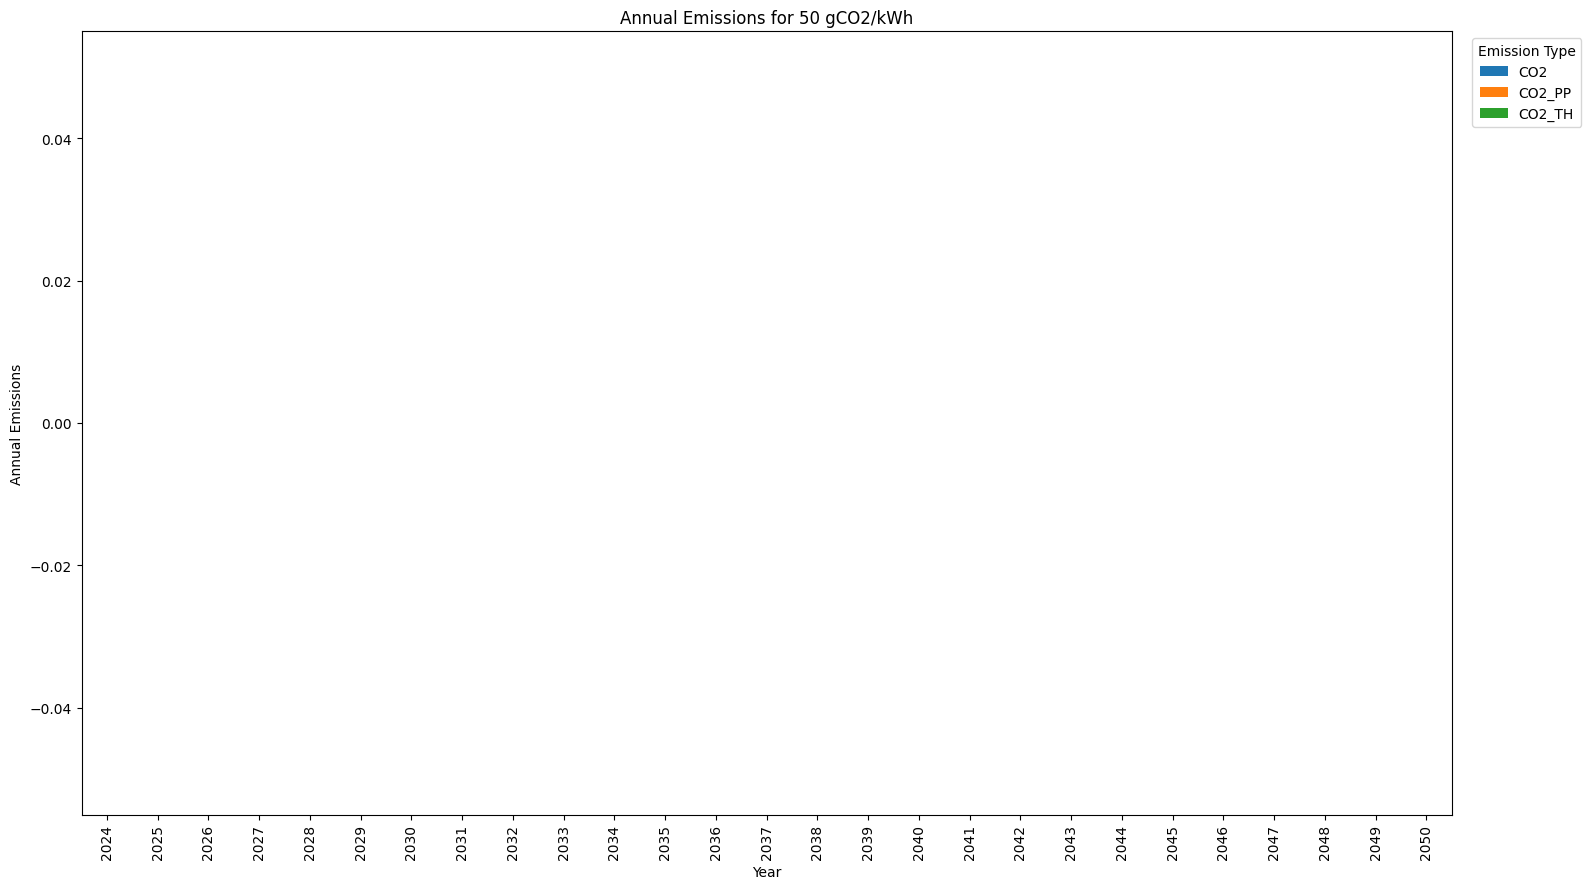

     REGION EMISSION  YEAR       Level  Marginal  Lower  Upper  Scale
0   GERMANY      CO2  2024  233.000000       0.0    0.0    inf    1.0
1   GERMANY      CO2  2025  223.655613       0.0    0.0    inf    1.0
2   GERMANY      CO2  2026  199.375835       0.0    0.0    inf    1.0
3   GERMANY      CO2  2027  198.006634       0.0    0.0    inf    1.0
4   GERMANY      CO2  2028  195.665963       0.0    0.0    inf    1.0
..      ...      ...   ...         ...       ...    ...    ...    ...
76  GERMANY   CO2_TH  2046  150.599559       0.0    0.0    inf    1.0
77  GERMANY   CO2_TH  2047  150.428011       0.0    0.0    inf    1.0
78  GERMANY   CO2_TH  2048  150.641389       0.0    0.0    inf    1.0
79  GERMANY   CO2_TH  2049  151.261051       0.0    0.0    inf    1.0
80  GERMANY   CO2_TH  2050  152.308359       0.0    0.0    inf    1.0

[81 rows x 8 columns]


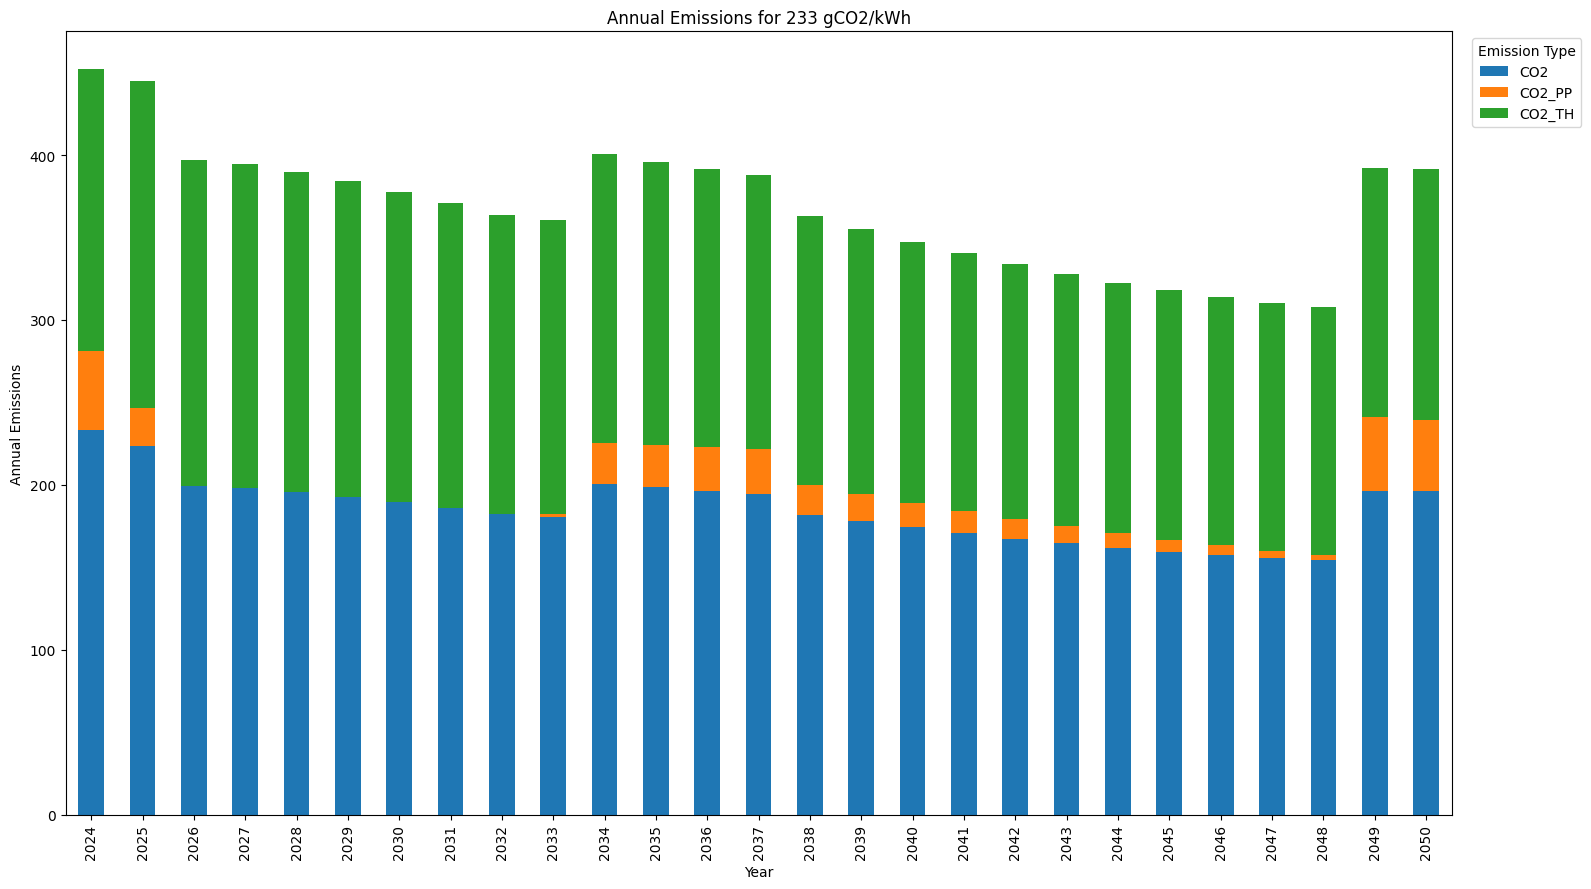

     REGION EMISSION  YEAR       Level  Marginal  Lower  Upper  Scale
0   GERMANY      CO2  2024  261.859948       0.0    0.0    inf    1.0
1   GERMANY      CO2  2025  223.655613       0.0    0.0    inf    1.0
2   GERMANY      CO2  2026  199.375835       0.0    0.0    inf    1.0
3   GERMANY      CO2  2027  198.006634       0.0    0.0    inf    1.0
4   GERMANY      CO2  2028  195.665963       0.0    0.0    inf    1.0
..      ...      ...   ...         ...       ...    ...    ...    ...
76  GERMANY   CO2_TH  2046  150.599559       0.0    0.0    inf    1.0
77  GERMANY   CO2_TH  2047  150.428011       0.0    0.0    inf    1.0
78  GERMANY   CO2_TH  2048  150.641389       0.0    0.0    inf    1.0
79  GERMANY   CO2_TH  2049  151.261051       0.0    0.0    inf    1.0
80  GERMANY   CO2_TH  2050  152.308359       0.0    0.0    inf    1.0

[81 rows x 8 columns]


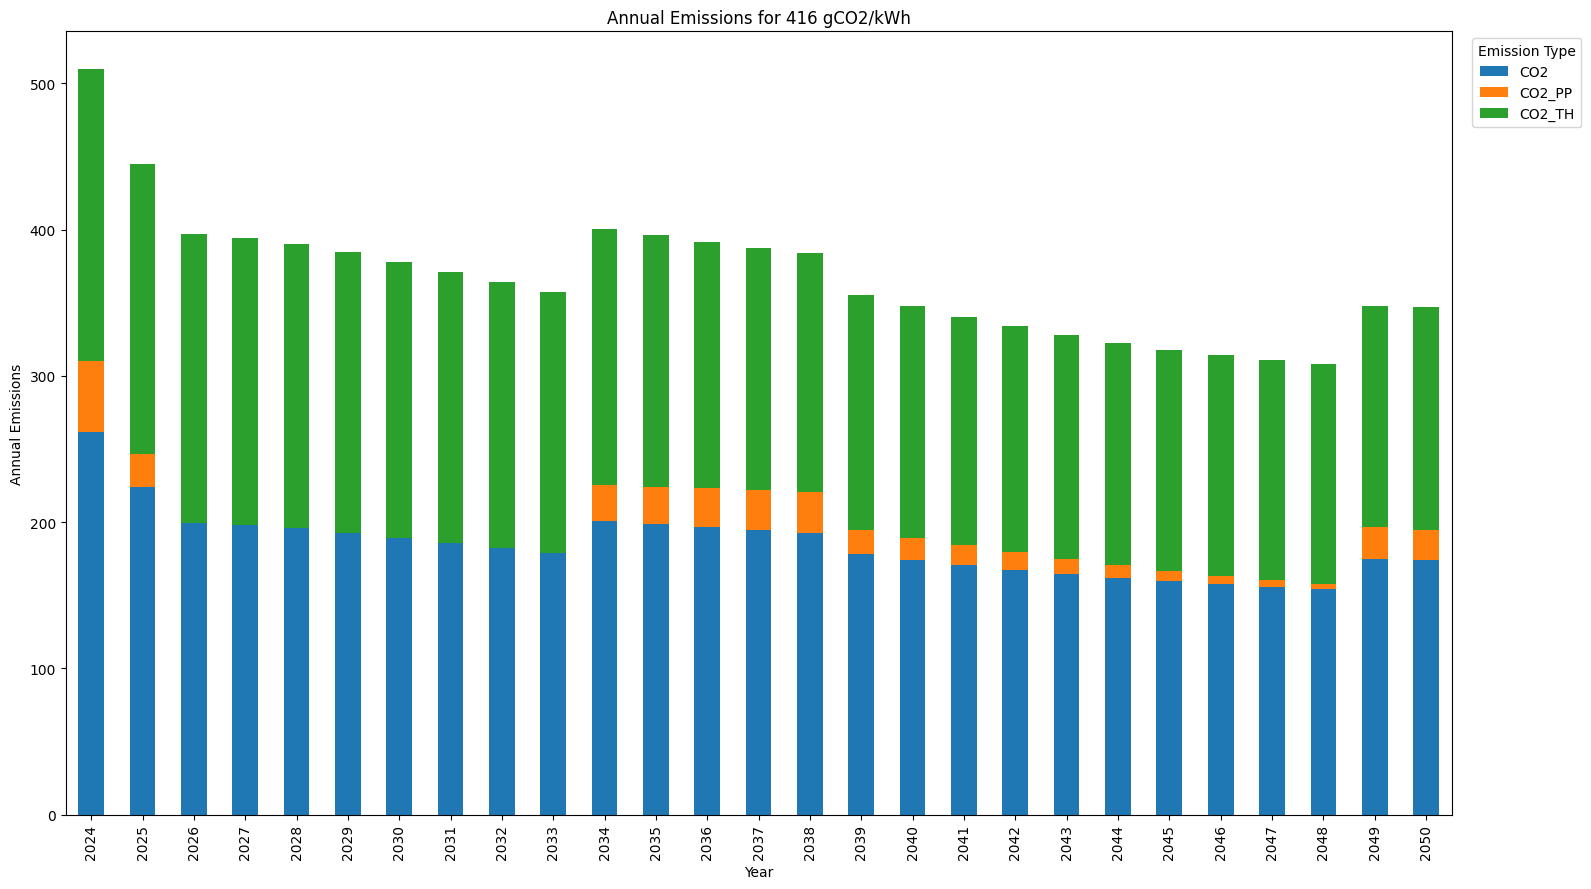

     REGION EMISSION  YEAR       Level  Marginal  Lower  Upper  Scale
0   GERMANY      CO2  2024  261.859948       0.0    0.0    inf    1.0
1   GERMANY      CO2  2025  223.655613       0.0    0.0    inf    1.0
2   GERMANY      CO2  2026  199.375835       0.0    0.0    inf    1.0
3   GERMANY      CO2  2027  198.006634       0.0    0.0    inf    1.0
4   GERMANY      CO2  2028  195.665963       0.0    0.0    inf    1.0
..      ...      ...   ...         ...       ...    ...    ...    ...
76  GERMANY   CO2_TH  2046  150.599559       0.0    0.0    inf    1.0
77  GERMANY   CO2_TH  2047  150.428011       0.0    0.0    inf    1.0
78  GERMANY   CO2_TH  2048  150.641389       0.0    0.0    inf    1.0
79  GERMANY   CO2_TH  2049  151.261051       0.0    0.0    inf    1.0
80  GERMANY   CO2_TH  2050  152.308359       0.0    0.0    inf    1.0

[81 rows x 8 columns]


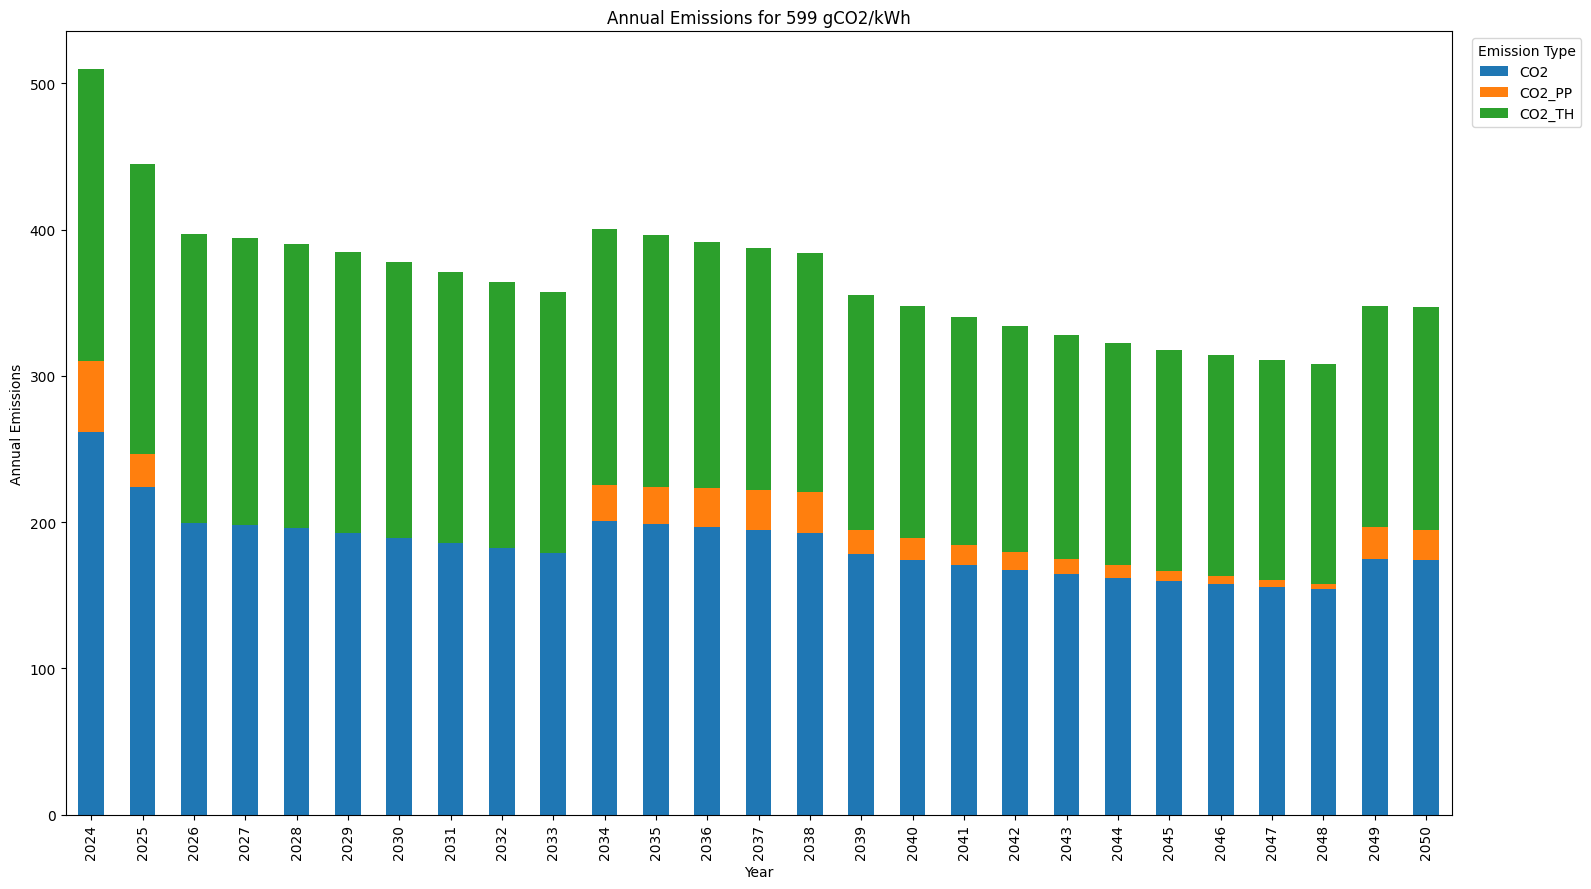

In [4]:
## here, dfs relate to emissions, let us plot them
for i, df in dfs.items():
    em_df = df
    print(df)
    pivot = em_df.pivot(index='YEAR', columns='EMISSION', values='Level')

    pivot.plot(kind='bar', stacked=True, figsize=(16, 9), title=f"Annual Emissions for {emissionC02[i]} gCO2/kWh")
    plt.xlabel('Year')
    plt.ylabel('Annual Emissions')
    plt.title(f"Annual Emissions for {emissionC02[i]} gCO2/kWh")
    plt.legend(title='Emission Type', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()

In [ ]:
##write gams file parameters

#StorageUnitSize(r, 'UHS', y) = 200;
#CapitalCost() hydrogen, primary_fuels, secondary_fuels
#emissionscap / emissions tax
#scenario UHS prioritised

with open("pytest_data.gms", "w") as f:
    for r, t, y, val in data:
        f.write(f"CapitalCost('{r}','{t}','{y}') = {val};\n")

In [ ]:
with open("pytest_data.gms", "w") as f:
    for r, t, y, val in data:
        f.write(f"CapitalCost('{r}','{t}','{y}') = {val};\n")

# Storage plots

In [ ]:
#totaldiscountstoragecost


#storagelevelyear start
#storagelevelyear finish
#storagelevelseason start
#totalcapacityannual